# Librerias

In [1]:
# from oficial python
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch
from matplotlib import cm
import matplotlib as mpl
from qutip import basis
import time
from sklearn.model_selection import train_test_split
import os
from qutip import sigmaz, sigmax, sigmay, mesolve




# own modules:
from dll.spin_procesor_modificated import Quantum_Spin_Proces
from dll.main_fun import make_IRIS_v2
from dll.main_fun import pulse_x_cos, pulse_x
from dll. baseline_dru_v2 import Modelo_DRU
from dll.models import qcircuit_1_qubit_mixed
from dll.cost_functions import fidelity_cost
from dll.gate_procesor_modificated import CompositeGateProcessor
from dll.plot_expectation_values import plot_excharges, plot_expect

# Funciones

In [5]:
color_palette = [
    "#0f5492", "#cc6e0b", "#206821", "#a01d1d",
    "#704c92", "#63403a", "#9f5f91", "#666666",
    "#8c9520", "#118c9f", "#94b5d1", "#d18e56",
    "#75b871", "#d18f8d", "#a28bbf", "#a07d76"]

In [6]:
def plot_measure_continuous(ax, t, probability_i, i, arrow, tf_noise = False):
    if tf_noise == True:
        label_str = rf"$\left| \{arrow} \right\rangle_{{noisy}}$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$\left| {arrow_str} \right\rangle_{{noisy}}$"
    else:
        label_str = rf"$\left| \{arrow} \right\rangle$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$\left| {arrow_str} \right\rangle$"
    ax.plot(t*1e9, probability_i, c=color_palette[i],
            alpha=0.7, label = label_str)

In [7]:
def plot_measure_scatter(ax, t, probability_i, i, arrow, N=100, random_seed=None, tf_noise = False):
    #if random_seed is not None:
    #    np.random.seed(random_seed)

    if tf_noise == True:
        label_str = rf"$\left| \{arrow} \right\rangle_{{noisy}}$"
    else:
        label_str = rf"$\left| \{arrow} \right\rangle$"

    # Convertir probability_i a un array numpy si no lo es
    probability_i = np.array(probability_i)

    # Seleccionar N índices aleatorios de los datos
    random_indices = np.random.choice(len(t), size=N, replace=False).astype(int)
    selected_t = t[random_indices]
    selected_probability_i = probability_i[random_indices]

    # Crear lista de 16 tipos de marcadores distintos
    marker_types = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '>', '<', 'h', 'd', '|', '_', '+', '.']

    ax.scatter(selected_t*1e9, selected_probability_i, c=color_palette[i],
                alpha=0.7, label = label_str, s=10,
                  marker=marker_types[i])

In [8]:
def calculate_T1(T2, T2start):
    T1 = (1/2)*((T2*T2start)/(T2start - T2))
    return T1

In [9]:
def measure_compuse_states(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_0 = []
    Measure_1 = []
    for i in range(n_states_time):

        states_i = procesor.states_in_time[i]
        get_statest = [state.full() for state in states_i]

        state_0 = list_states_overlap[0]
        probability_0 = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
        Measure_0.extend(probability_0)

        state_1 = list_states_overlap[1]
        probability_1 = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]
        Measure_1.extend(probability_1)

    time = np.linspace(0, procesor.global_time, len(Measure_1))
    return time, Measure_0, Measure_1

#### 2 qubits

In [10]:
def measure_compuse_states_2q(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_i = [[] for _ in range(len(list_states_overlap))]

    for i in range(n_states_time):
        for j,state_measure in enumerate(list_states_overlap):

            states_i = procesor.states_in_time[i]
            get_statest = [state.full() for state in states_i]
            _,nc = get_statest[0].shape
            #print(nc)
            if nc == 1:
                probability_i = [np.abs(state_measure @ state)[0][0]**2 for state in get_statest]
            else:
                probability_i = [np.abs((state_measure @ state @ state_measure.T)[0][0]) for state in get_statest]
            Measure_i[j].extend(probability_i)

    time = np.linspace(0, procesor.global_time, len(Measure_i[0]))
    return time, Measure_i

# I. Pruebas Modelo

## I.I. Qubit - tiempo

### I.I.I. Rotation $R_x$

#### Real Hamiltonian

Hamiltoniano real sin aproximacion RWA.

Ahora se simula el hamiltoniano sin aproximación.

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


-0.0007544794237181623
-0.7071016731095187
0.7071114867165703


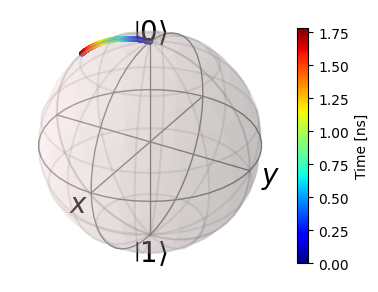

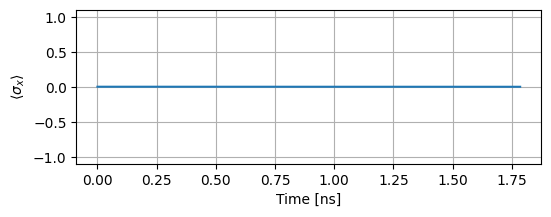

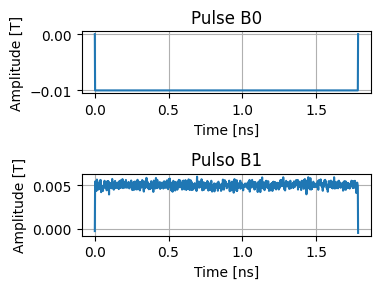

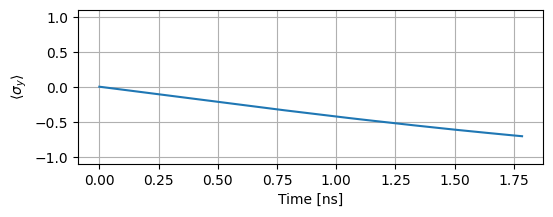

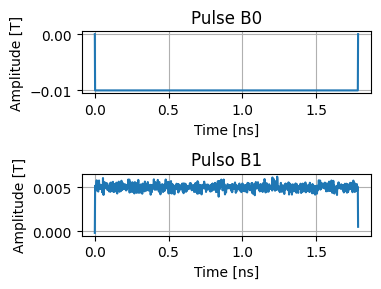

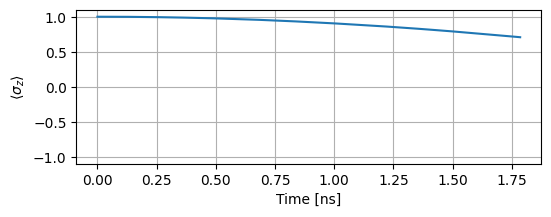

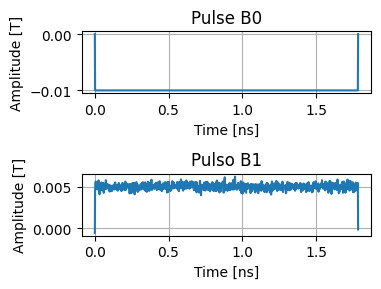

In [3]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, n_points_pulse_Ri_spl=1000, tf_noise=True, noise_std=0.00033, save_pulses=True, nf = 4)
alpha = np.pi/4
out = procesor_1.Rx(alpha, ket_0, tf_expect=True)

print(out.expect[0][-1])
print(out.expect[1][-1])
print(out.expect[2][-1])

plot_expect(procesor_1, out, False, index=0, path_to_save_img = os.path.join("results_of_test","test_4"))

plot_excharges(procesor_1, out, index=0, ry_tf =False, nick_name="Rx", path_to_save_img = os.path.join("results_of_test","test_4"))
plot_excharges(procesor_1, out, index=1, ry_tf =False, nick_name="Rx",  path_to_save_img = os.path.join("results_of_test","test_4"))
plot_excharges(procesor_1, out, index=2, ry_tf =False, nick_name="Rx",  path_to_save_img = os.path.join("results_of_test","test_4"))

#### Without noise

In [11]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, nf=4, save_time_values=True)

# ANGULO:
alpha = 3*np.pi

out = procesor_1.Rx(alpha, ket_0, tf_expect=False)

# get tme and states:
t = procesor_1.tlist
get_statest = [state.full() for state in out.states]

# Measure:
# P0
state_0 = np.array([[1, 0]])
probability_0 = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
# P1
state_1 = np.array([[0, 1]])
probability_1 = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]


list_states_overlap = [np.array([[1, 0]]),
                       np.array([[0, 1]])]

t, m = measure_compuse_states_2q(procesor_1, list_states_overlap)
probability_0 = m[0]
probability_1 = m[1]



#### with noise coherent

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Tiempo de ejecución: 0.05860280990600586 segundos


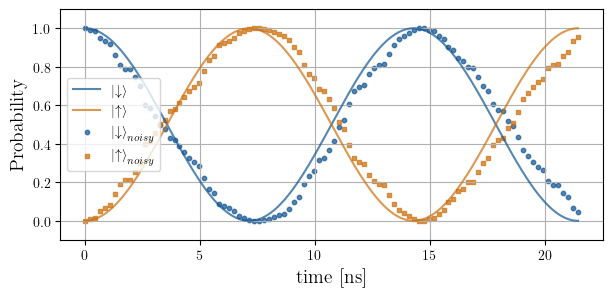

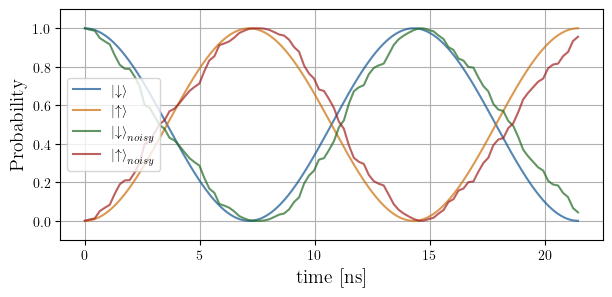

In [13]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
Npoints = 100
inicio = time.time()
procesor_2 = Quantum_Spin_Proces(n_points_pulse_Ri = Npoints, version_qutip="5",
                                  n_points_pulse_Ri_spl=1500,
                                    tf_noise = True, noise_std = 0.0095,
                                      nstepsolver = 1000, save_pulses=True, save_time_values=True)
# ANGULO:
alpha = 3*np.pi

out = procesor_2.Rx(alpha, ket_0, tf_expect=False)
fin = time.time()

# Calculamos el tiempo de ejecución
tiempo_ejecucion = fin - inicio
print("Tiempo de ejecución:", tiempo_ejecucion, "segundos")

# get tme and states:
t_noisy = procesor_2.tlist
get_statest = [state.full() for state in out.states]

# Measure:
# P0
state_0 = np.array([[1, 0]])
probability_0_noisy = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
# P1
state_1 = np.array([[0, 1]])
probability_1_noisy = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]


t_noisy, mn = measure_compuse_states_2q(procesor_2, list_states_overlap)
probability_0_noisy  = mn[0]
probability_1_noisy = mn[1]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t_noisy, probability_0_noisy, 0,  'downarrow', N=Npoints, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t_noisy, probability_1_noisy, 1, 'uparrow', N=Npoints, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_in_time_withc_c_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, m[0], 0, 'downarrow')
plot_measure_continuous(ax, t, m[1], 1, 'uparrow')
plot_measure_continuous(ax, t_noisy, probability_0_noisy, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t_noisy, probability_1_noisy, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_in_time_withc_c_noise_scatter.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

#### with quantum noisy

1.176529588766299e-08


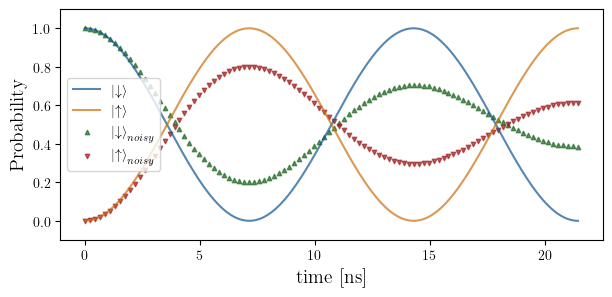

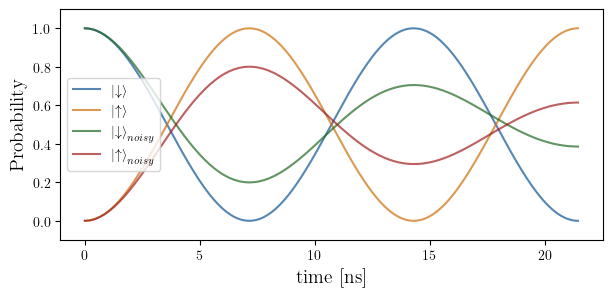

In [14]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
print(T1c)

Npoints = 100

procesor_3 = Quantum_Spin_Proces(n_points_pulse_Ri = Npoints, tf_noise = False, noise_std = 0.0159,
                                  tf_quantum_noise = True, T1= T1c, T2 = T2c)
angle= 3*np.pi
out = procesor_3.Rx(angle, ket_0, tf_expect=False)

# get tme and states:
t_noisy_q = procesor_3.tlist
get_statest = [state.full() for state in out.states]

# Measure:
# P0
state_0 = np.array([[1, 0]])
# probability_0_noisy_q = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
probability_0_noisy_q = [np.abs((state_0 @ state @ state_0.T)[0][0]) for state in get_statest]

# P1
state_1 = np.array([[0, 1]])
# probability_1_noisy_q = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]
probability_1_noisy_q = [np.abs((state_1 @ state @ state_1.T)[0][0]) for state in get_statest]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t_noisy_q, probability_0_noisy_q, 2,  'downarrow', N=Npoints, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t_noisy_q, probability_1_noisy_q, 3, 'uparrow', N=Npoints, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_with_q_noise_scatter.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_continuous(ax, t_noisy_q, probability_0_noisy_q, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t_noisy_q, probability_1_noisy_q, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_with_q_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

In [15]:
procesor_3.H2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.0e+00 2.2e+08]
 [2.2e+08 0.0e+00]]

1.176529588766299e-06


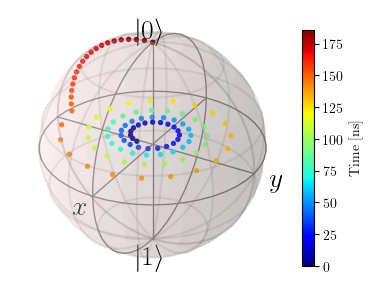

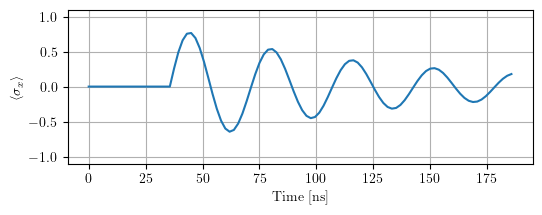

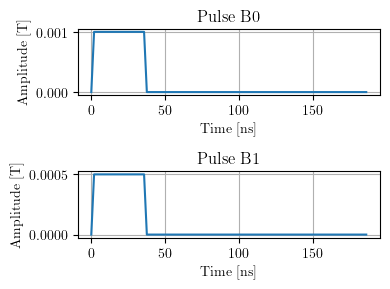

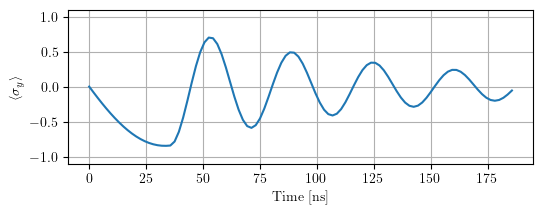

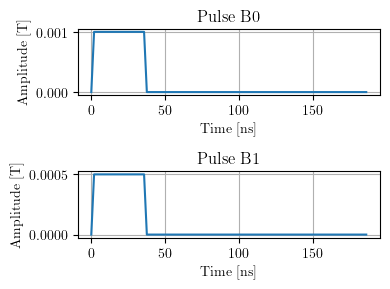

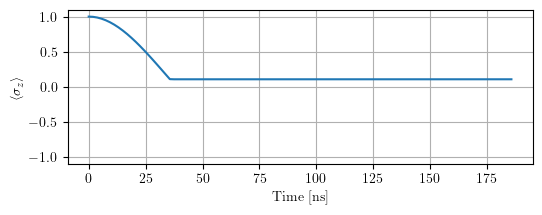

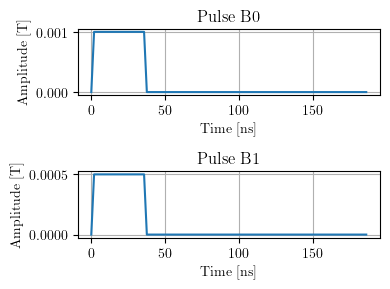

In [16]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
T2c = 2.3e-6
T2start = 102e-6
T1c = calculate_T1(T2c, T2start)
print(T1c)

Npoints = 100

procesor_3 = Quantum_Spin_Proces(n_points_pulse_Ri = Npoints, tf_noise = False, noise_std = 0.0159, B0=1e-3,
                                  tf_quantum_noise = True, T1= 1e-3, T2 = 100e-9, free_time=150e-9)
angle= np.pi/2
out = procesor_3.Rx(angle, ket_0, tf_expect=True)

plot_expect(procesor_3, out, False, index=0, path_to_save_img = os.path.join("results_of_test","test_4"))

plot_excharges(procesor_3, out, index=0, ry_tf =False, nick_name="Rx_qn", path_to_save_img = os.path.join("results_of_test","test_4"))
plot_excharges(procesor_3, out, index=1, ry_tf =False, nick_name="Rx_qn",  path_to_save_img = os.path.join("results_of_test","test_4"))
plot_excharges(procesor_3, out, index=2, ry_tf =False, nick_name="Rx_qn",  path_to_save_img = os.path.join("results_of_test","test_4"))

#### with both noises

1.176529588766299e-08


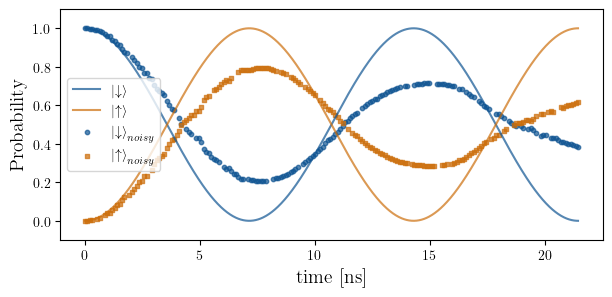

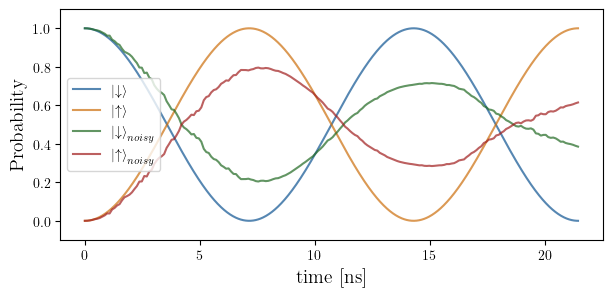

In [17]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
print(T1c)

Npoints = 200

procesor_4 = Quantum_Spin_Proces(n_points_pulse_Ri = Npoints, tf_noise = True, noise_std = 0.00509,
                                  tf_quantum_noise = True, T1= T1c, T2 = T2c, version_qutip="5")
angle = 3*np.pi
out = procesor_4.Rx(angle, ket_0, tf_expect=False)

# get tme and states:
t_noisy_cq = procesor_4.tlist
get_statest = [state.full() for state in out.states]

# Measure:
# P0
state_0 = np.array([[1, 0]])
# probability_0_noisy_q = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
probability_0_noisy_cq = [np.abs((state_0 @ state @ state_0.T)[0][0]) for state in get_statest]

# P1
state_1 = np.array([[0, 1]])
# probability_1_noisy_q = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]
probability_1_noisy_cq = [np.abs((state_1 @ state @ state_1.T)[0][0]) for state in get_statest]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t_noisy_cq, probability_0_noisy_cq,0,  'downarrow', N=Npoints-25, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t_noisy_cq, probability_1_noisy_cq, 1, 'uparrow', N=Npoints-25, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_with_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()




fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_continuous(ax, t_noisy_cq, probability_0_noisy_cq, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t_noisy_cq, probability_1_noisy_cq, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rx_with_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

### $R_z$

In [43]:
def measure_quantum_states(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_i = [[] for _ in range(len(list_states_overlap))]

    for i in range(n_states_time):
        for j, state_measure in enumerate(list_states_overlap):

            states_i = procesor.states_in_time[i]
            get_statest = [state.full() for state in states_i]
            _,nc = get_statest[0].shape
            if nc == 1:
                probability_i = [np.abs(state_measure @ state)[0][0]**2 for state in get_statest]
            else:
                probability_i = [np.abs((state_measure @ state @ state_measure.T)[0][0]) for state in get_statest]
            Measure_i[j].extend(probability_i)

    time = np.linspace(0, procesor.global_time, len(Measure_i[0]))
    return time, Measure_i

In [48]:
ket_00 = basis(2, 0)
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))
ket_1 = (basis(2, 0) - basis(2, 1))*(1/np.sqrt(2))

list_overlap = [ket_0.full().T, ket_1.full().T]

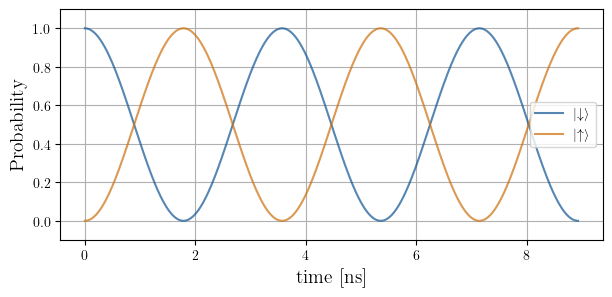

In [51]:
# Estado inicial
ket_00 = basis(2, 0)
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))
ket_1 = (basis(2, 0) - basis(2, 1))*(1/np.sqrt(2))

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, save_time_values=True)
angle = -5*np.pi
out = procesor_1.Rz(angle, ket_0, tf_expect=False)

# Measure 2:
list_overlap = [ket_0.full().T, ket_1.full().T]
t, measure = measure_quantum_states(procesor_1, list_overlap)
probability_0 = measure[0]
probability_1 = measure[1]


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_Rz_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

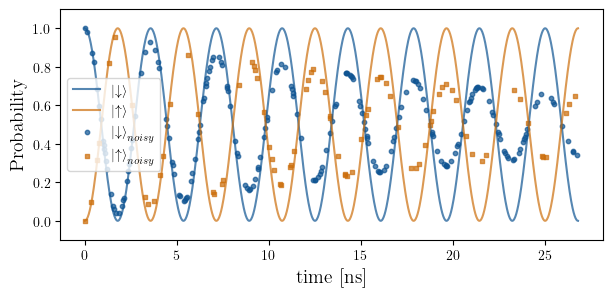

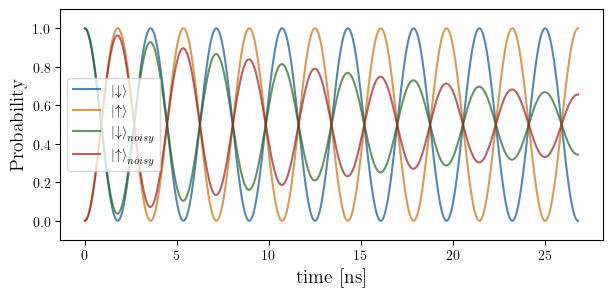

In [55]:
# Estado inicial
ket_00 = basis(2, 0)
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, save_time_values=True)
angle = -15*np.pi
out = procesor_1.Rz(angle, ket_0, tf_expect=False)


# Measure 2:
list_overlap = [ket_0.full().T, ket_1.full().T]
t, measure = measure_quantum_states(procesor_1, list_overlap)
probability_0 = measure[0]
probability_1 = measure[1]


# =================
# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

procesor_4 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, tf_noise = True, noise_std = 0.0159,
                                  tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True)
angle = -15*np.pi
out = procesor_4.Rz(angle, ket_0, tf_expect=False)




# Measure 2:
list_overlap = [ket_0.full().T, ket_1.full().T]
t_noisy_cq, measure = measure_quantum_states(procesor_4, list_overlap)
probability_0_noisy_cq = measure[0]
probability_1_noisy_cq = measure[1]


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t_noisy_cq, probability_0_noisy_cq,0,  'downarrow', N=200, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t_noisy_cq, probability_1_noisy_cq, 1, 'uparrow', N=80, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rz_with_q_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()




fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_continuous(ax, t_noisy_cq, probability_0_noisy_cq, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t_noisy_cq, probability_1_noisy_cq, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Rz_with_q_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

### $R_y$

In [56]:
# Estado inicial
ket_0 = basis(2, 0)

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000,  save_time_values = True)
angle = (3/2)*np.pi + 0.4
out = procesor_1.Ry(angle, ket_0, tf_expect=False)

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t,probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)




#### Bloch sphere visualization

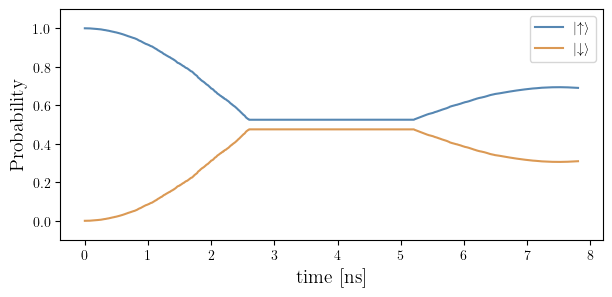

In [21]:
# Estado inicial
ket_0 = basis(2, 0)

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, tf_noise=True, noise_std=0.003,  save_time_values = True)
angle = (3/2)*np.pi + 0.4
out = procesor_1.Ry(angle, ket_0, tf_expect=False)

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t,probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0,  'uparrow')
plot_measure_continuous(ax, t, probability_1, 1, 'downarrow')
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Ry_with_c_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

#### with both noise

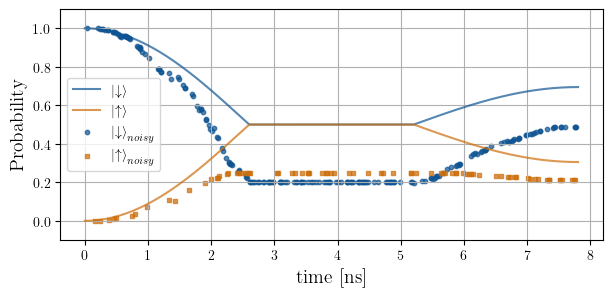

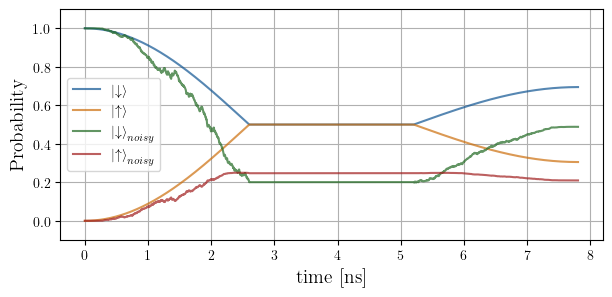

In [23]:
# Estado inicial
ket_0 = basis(2, 0)
angle = (3/2)*np.pi + 0.4
# =================
# Def procesador

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, save_time_values=True)
angle = (3/2)*np.pi + 0.4
out = procesor_1.Ry(angle, ket_0, tf_expect=False)

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t, probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)


# Noise:
T2c = 2.3e-6
T2start = 102e-6
T1c = calculate_T1(T2c, T2start)

procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, tf_noise=True, noise_std=0.02, tf_quantum_noise=True, T1 = T1c, T2 = T2c , save_time_values=True)
out = procesor_1.Ry(angle, ket_0, tf_expect=False)

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t,probability_0_noisy_cq, probability_1_noisy_cq = measure_compuse_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t, probability_0_noisy_cq,0,  'downarrow', N=200, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t, probability_1_noisy_cq, 1, 'uparrow', N=80, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Ry_with_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()


fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_continuous(ax, t, probability_0_noisy_cq, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t, probability_1_noisy_cq, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_4","probability_Ry_with_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()

### $L(i)$


#### Fit base line { $\omega^{*}$, $\theta^{*}$ }

In [24]:
N_layeres = 2
n_classes = 3
n_features = 2


X, y =  make_IRIS_v2(n_features, n_classes)


model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 1, n_clases = n_classes, n_qubits = 1,
                   features = n_features, alpha_noise = 0.0, save_process=False,
                   num_layers = N_layeres)

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


#### Spin processor

In [25]:
# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000, n_points_pulse_Ri_spl=1000,                                     N_qubits = 1,
                                    tf_noise = False, noise_std = 0.019,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c, save_time_values=True)
state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)


list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t,probability_0, probability_1 = measure_compuse_states(dru_circuit, list_states_overlap)



# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,n_points_pulse_Ri_spl=1000,
                                     N_qubits = 1,
                                    tf_noise = True, noise_std = 0.019,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True)
state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t,probability_0_noisy_cq, probability_1_noisy_cq = measure_compuse_states(dru_circuit, list_states_overlap)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


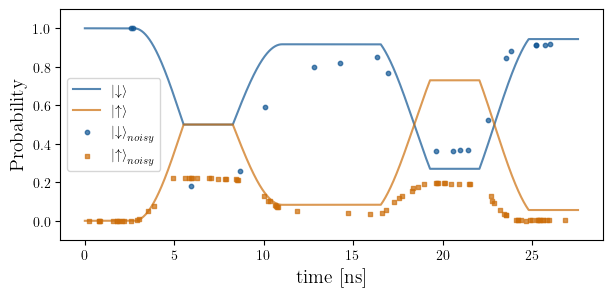

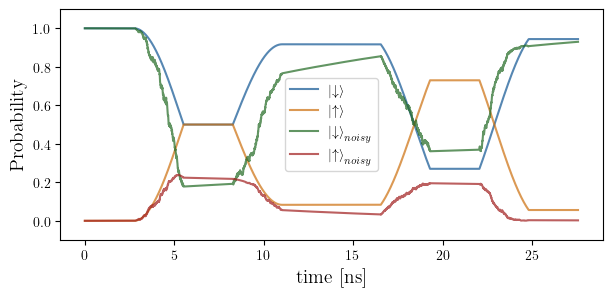

In [26]:

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_scatter(ax, t, probability_0_noisy_cq,0,  'downarrow', N=20, random_seed=42, tf_noise = True)
plot_measure_scatter(ax, t, probability_1_noisy_cq, 1, 'uparrow', N=80, random_seed=42, tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_L_with_both_noise_scatter.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'downarrow')
plot_measure_continuous(ax, t, probability_1, 1, 'uparrow')
plot_measure_continuous(ax, t, probability_0_noisy_cq, 2, 'downarrow', tf_noise = True)
plot_measure_continuous(ax, t, probability_1_noisy_cq, 3, 'uparrow', tf_noise = True)
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
path_to_save_img = os.path.join("results_of_test","test_4","probability_L_with_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()

## 2 Qubits - tiempo

#### CZ

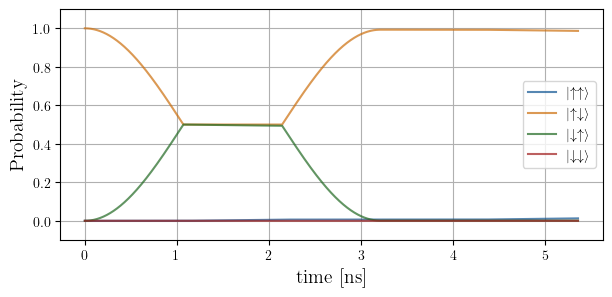

In [27]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 0),basis(2, 1))


# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                  J = 1e12, tf_noise = True, noise_std = 0.099,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True,
                                    n_points_pulse_2Qbits=1000)

out = procesor_1.CZ(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]

time, m = measure_compuse_states_2q(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()

path_to_save_img = os.path.join("results_of_test","test_4","probability_CZ_with_q_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()

#### CNOT

In [28]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 1),basis(2, 1))

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2, J = 1e12, save_time_values=True, n_points_pulse_2Qbits=1000)
out = procesor_1.CNOT(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]
time, m = measure_compuse_states_2q(procesor_1, list_states_overlap)


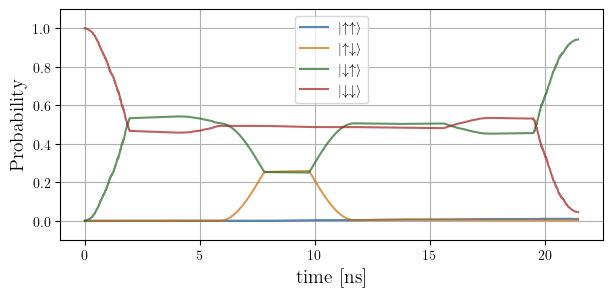

In [29]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 1),basis(2, 1))

# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                  J = 1e12, tf_noise = True, noise_std = 0.0059,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True, n_points_pulse_2Qbits=1000)
out = procesor_1.CNOT(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                       np.array([[0, 0, 0, 1]])]


time, m = measure_compuse_states_2q(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()

path_to_save_img = os.path.join("results_of_test","test_4","probability_CNOT_with_q_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()

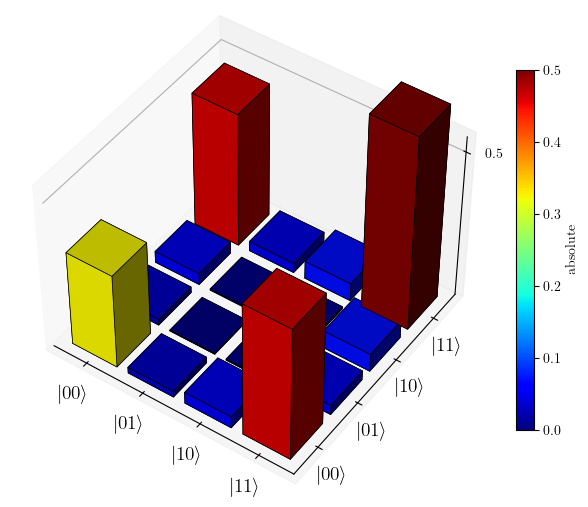

In [30]:
from qutip import tensor, basis
from qutip import matrix_histogram

latex_strings = [
    r"$|00\rangle$",
    r"$|01\rangle$",
    r"$|10\rangle$",
    r"$|11\rangle$"
]

ket_0 = tensor(basis(2, 0),basis(2, 0))

# Def procesador
T2c = 22e-6
T2start = 102e-6
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                  J = 1e12, tf_noise = True, noise_std = 0.029,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c)

out = procesor_1.H(ket_0, q_obj=0).states[-1]
out = procesor_1.CNOT(out, [], tf_expectt=False)

fig, ax = matrix_histogram(out * out.dag(),latex_strings, latex_strings, 
                           limits = [0.,0.55], color_limits = [0.,0.5], color_style="abs")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_4","thomography_bell_1_both_noises.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()

## 4 Qubits - tiempo

In [31]:
def measure_compuse_states_2q(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_i = [[] for _ in range(len(list_states_overlap))]

    for i in range(n_states_time):
        for j,state_measure in enumerate(list_states_overlap):

            states_i = procesor.states_in_time[i]
            get_statest = [state.full() for state in states_i]
            _,nc = get_statest[0].shape
            if nc == 1:
                probability_i = [np.abs(state_measure @ state)[0][0]**2 for state in get_statest]
            else:
                probability_i = [np.abs((state_measure @ state @ state_measure.T)[0][0]) for state in get_statest]
            Measure_i[j].extend(probability_i)

        time = np.linspace(0, procesor.global_time, len(Measure_i[0]))
    return time, Measure_i

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


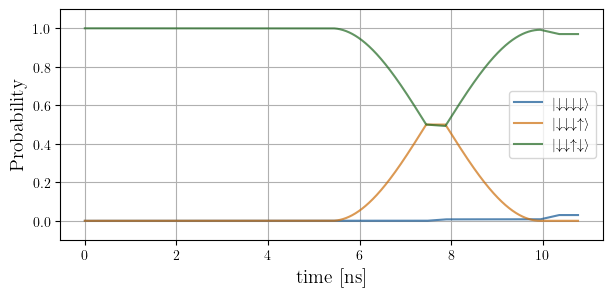

In [32]:
#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [0,1])
#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [2,3])

from qutip import tensor
#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [1,2], tf_expectt =False)
#self.ket_dru_0 = self.CZ_4(self.ket_dru_0, q_obj=[0,3], tf_expect=False)


# 4 binario
ket_0 = tensor(basis(2, 0),basis(2, 0), basis(2, 1), basis(2, 0))

# Def procesador
T2c = 2.3e-7
T2start = 102e-7
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,n_points_pulse_2Qbits=500,
                                     N_qubits = 4,
                                    tf_noise = True, noise_std = 0.0099,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True)

ket_dru_0 = dru_circuit.CZ(ket_0, [], q_obj = [0,1])
ket_dru_0 = dru_circuit.CZ(ket_dru_0, [], q_obj = [2,3])



states_4q = []
for i in range(16):
    estado_base = np.zeros((1,16))
    estado_base[0][i] = 1
    states_4q.append(estado_base)


time, m = measure_compuse_states_2q(dru_circuit, states_4q)



# Lista de flechas para los estados base de 4 qubits
bases_strings = [
    [r"\downarrow", r"\downarrow", r"\downarrow", r"\downarrow"],
    [r"\downarrow", r"\downarrow", r"\downarrow", r"\uparrow"],
    [r"\downarrow", r"\downarrow", r"\uparrow", r"\downarrow"],
    [r"\downarrow", r"\downarrow", r"\uparrow", r"\uparrow"],
    [r"\downarrow", r"\uparrow", r"\downarrow", r"\downarrow"],
    [r"\downarrow", r"\uparrow", r"\downarrow", r"\uparrow"],
    [r"\downarrow", r"\uparrow", r"\uparrow", r"\downarrow"],
    [r"\downarrow", r"\uparrow", r"\uparrow", r"\uparrow"],
    [r"\uparrow", r"\downarrow", r"\downarrow", r"\downarrow"],
    [r"\uparrow", r"\downarrow", r"\downarrow", r"\uparrow"],
    [r"\uparrow", r"\downarrow", r"\uparrow", r"\downarrow"],
    [r"\uparrow", r"\downarrow", r"\uparrow", r"\uparrow"],
    [r"\uparrow", r"\uparrow", r"\downarrow", r"\downarrow"],
    [r"\uparrow", r"\uparrow", r"\downarrow", r"\uparrow"],
    [r"\uparrow", r"\uparrow", r"\uparrow", r"\downarrow"],
    [r"\uparrow", r"\uparrow", r"\uparrow", r"\uparrow"]
]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
for i in range(16):
    if any(m[i]):
        plot_measure_continuous(ax, time, m[i], i, bases_strings[i])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()

path_to_save_img = os.path.join("results_of_test","test_4","probability_4Q_CZ_v1_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')


plt.show()



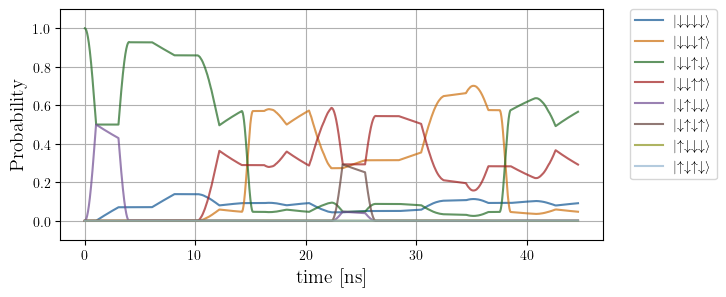

In [33]:
from qutip import tensor



# 4 binario
ket_0 = tensor(basis(2, 0),basis(2, 0), basis(2, 1), basis(2, 0))

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000, n_points_pulse_2Qbits=500,
                                     N_qubits = 4,
                                     J = 1e12,
                                    tf_noise = True, noise_std = 0.0019,
                                    tf_quantum_noise = True, T1= T1c, T2 = T2c, save_time_values=True)



ket_dru_0  = dru_circuit.CZ(ket_0, [], q_obj = [1,2], tf_expectt =False)
ket_dru_0 = dru_circuit.CZ_4(ket_dru_0 , q_obj=[0,3], tf_expect=False)

states_4q = []
for i in range(16):
    estado_base = np.zeros((1,16))
    estado_base[0][i] = 1
    states_4q.append(estado_base)


time, m = measure_compuse_states_2q(dru_circuit, states_4q)

def detect_all_zeros(m_list):
    umbral = 1e-3
    check_list = [valor < umbral for valor in m_list]
    return all(check_list)

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
for i in range(16):
    if detect_all_zeros(m[i])==False:
        plot_measure_continuous(ax, time, m[i], i, bases_strings[i])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
# Colocar la leyenda fuera del gráfico
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.grid()

path_to_save_img = os.path.join("results_of_test","test_4","probability_4Q_CZ_v2_both_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')

plt.show()


# II. Pruebas Fidelidad vs Ruido

# Pruebas definitivas

In [34]:
# from python
from sklearn.model_selection import train_test_split
from collections import defaultdict
import pennylane as qml
import json
from qutip import tensor
import time
from qutip import basis
import numpy as np
import matplotlib.pyplot as plt


# own modules:
from dll.gate_procesor_modificated import CompositeGateProcessor
from dll.main_fun import make_IRIS_v2
from dll.models import qcircuit_1_qubit_mixed, qcircuit_2_qubit_mixed, qcircuit_4_qubit_mixed
from dll.baseline_dru_v2 import Modelo_DRU
from dll.cost_functions import fidelity_cost

In [38]:
# Función para calcular el promedio y la desviación estándar de una lista
def calcular_estadisticas(lista):
    promedio = np.mean(lista)
    desviacion_estandar = np.std(lista)
    return promedio, desviacion_estandar

def Fidelity_mean(model_base_line, X, y, epocas, n_classes, nqubits, n_features , N_layers, range_std, ket_0 = basis(2, 0), entgl = False,
                  coherent_noise = True, quantum_noise = False, n_lim = 5, poinst = [70,70,100]):
    # diccionario vacio defaul lista:
    Fidelities = defaultdict(list)
    # fit base line model:
    model = Modelo_DRU(model_base_line, fidelity_cost,
                   epochs = epocas, n_clases = n_classes, n_qubits = nqubits,
                   features = n_features, alpha_noise = 0.0, save_process=False,
                   num_layers = N_layers, entanglement=entgl)
    # get tuning parameters:
    
    # splita data:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # get parameters
    paramters_iq, bias_iq = model.fit(X_train, y_train, X_test, y_test)
    # fidelity vs coherent noise in XTest
    inicio = time.time()
    for std in range_std:
        for x in model.X_val[n_lim]:
            dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=poinst[0], n_points_pulse_Ri_spl = poinst[1], nstepsolver=poinst[2],
                                                N_qubits = nqubits,
                                                tf_noise = coherent_noise, noise_std = std,
                                                tf_quantum_noise = quantum_noise, T1= T1c, T2 = T2c,
                                                ket_dru_0 = ket_0, version_qutip="5", nf = 4)
            if nqubits == 1:
                state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_1_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
            elif nqubits == 2:
                state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_2_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
            elif nqubits == 4:
                state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_4_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)

            # get dm of spins:
            #print(state_dru)
            #return state_dru
            dm_from_spins = (state_dru*state_dru.dag()).full()
            # fidelity:
            F  = qml.math.fidelity(dm_from_spins, dm_baseline)
            # save fidelity
            Fidelities[f"{nqubits}q_e_{entgl}_cn_{std}_qn_false"].append(F)
    # Tiempo:
    fin = time.time()
    # Calcular el tiempo transcurrido
    tiempo_transcurrido = fin - inicio
    print("El código tardó {:.5f} segundos en ejecutarse.".format(tiempo_transcurrido))
    
    # convert dict defaul list to json:
    diccionario_estandar = dict(Fidelities)
    # Exportar el diccionario como JSON
    with open("results_of_test/test_4/" + f"{nqubits}q_e_{entgl}_cn_{coherent_noise}_qn_{quantum_noise}_.json", 'w') as file:
        json.dump(diccionario_estandar, file)

    # Plot:
    # Find mean and std fidelity:
    promedios = []
    desviaciones_estandar = []
    # Calcular los promedios y desviaciones estándar para cada lista en el diccionario
    for lista in Fidelities.values():
        promedio, desviacion_estandar = calcular_estadisticas(lista)
        promedios.append(promedio)
        desviaciones_estandar.append(desviacion_estandar)
    # Crear el plot de los promedios
    plt.figure(figsize=(5,3))
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.plot(range(len(promedios)), promedios, label = "Average fidelity")
    plt.xlabel(r'$\sigma_{cn} [T]$',fontsize=16)
    plt.ylabel('Fidelity',fontsize=16)
    # Añadir mini box plots
    for i, lista in enumerate(Fidelities.values()):
        plt.boxplot(lista, positions=[i], widths=0.3, showmeans=True,
                    meanline=True, meanprops={'color': 'red'})
    plt.ylim(0,1.1)
    # change ticks
    # Redondear y formatear las etiquetas del eje x
    # Rotar las etiquetas del eje x a 45 grados
    array_redondeado = np.round(range_std, decimals=4)
    #plt.xticks(x, nuevas_etiquetas, rotation=45)
    plt.xticks(np.arange(len(array_redondeado)), array_redondeado, rotation = 45)
    plt.legend()
    # results_of_test\test_3
    plt.savefig("results_of_test/test_4/" + f"{nqubits}q_e_{entgl}_cn_{coherent_noise}_qn_{quantum_noise}_.pdf", format='pdf', bbox_inches = 'tight')
    plt.show()


In [39]:
def Fidelity_mean_T2(model_base_line, X, y, epocas, n_classes, nqubits, n_features , N_layers, T2_range, T1_range,
                    ket_0 = basis(2, 0), entgl = False,
                  coherent_noise = True, quantum_noise = False, n_lim = 5, poinst = [70,70,100]):
    # diccionario vacio defaul lista:
  Fidelities = defaultdict(list)
  # fit base line model:
  model = Modelo_DRU(model_base_line, fidelity_cost,
                  epochs = epocas, n_clases = n_classes, n_qubits = nqubits,
                  features = n_features, alpha_noise = 0.0, save_process=False,
                  num_layers = N_layers, entanglement=entgl)
  # get tuning parameters:
    
  # splita data:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  # get parameters
  paramters_iq, bias_iq = model.fit(X_train, y_train, X_test, y_test)
  # fidelity vs coherent noise in XTest
  for i in range(len(T2_range)):
      for x in model.X_val[n_lim]:
          dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=poinst[0], n_points_pulse_Ri_spl = poinst[1], nstepsolver=poinst[2],
                                              N_qubits = nqubits,
                                              tf_noise = coherent_noise, noise_std = 0.0,
                                              tf_quantum_noise = quantum_noise, T1= T1_range[i], T2 = T2_range[i],
                                              ket_dru_0 = ket_0, nf = 4)
          if nqubits == 1:
              state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_iq,
                                                          x,
                                                          bias=bias_iq , entanglement=entgl)
              dm_baseline = qcircuit_1_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
          elif nqubits == 2:
              state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_iq,
                                                          x,
                                                          bias=bias_iq , entanglement=entgl)
              dm_baseline = qcircuit_2_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
          elif nqubits == 4:
              state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_iq,
                                                          x,
                                                          bias=bias_iq , entanglement=entgl)
              dm_baseline = qcircuit_4_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
        
          # get dm of spins:
          dm_from_spins = (state_dru*state_dru.dag()).full()
          # fidelity:
          F  = qml.math.fidelity(dm_from_spins, dm_baseline)
          # save fidelity
          Fidelities[f"{nqubits}q_e_{entgl}_cn_{0}_qn_{round(T2_range[i]*1e6,4)}"].append(F)
  # convert dict defaul list to json:
  diccionario_estandar = dict(Fidelities)
  # Exportar el diccionario como JSON
  with open("results_of_test/test_4/" + f"{nqubits}q_e_{entgl}_cn_{coherent_noise}_qn_{quantum_noise}_.json", 'w') as file:
      json.dump(diccionario_estandar, file)

  # Plot:
  # Find mean and std fidelity:
  promedios = []
  desviaciones_estandar = []
  # Calcular los promedios y desviaciones estándar para cada lista en el diccionario
  for lista in Fidelities.values():
      promedio, desviacion_estandar = calcular_estadisticas(lista)
      promedios.append(promedio)
      desviaciones_estandar.append(desviacion_estandar)
  # Crear el plot de los promedios
  plt.figure(figsize=(5,3))
  plt.rcParams['text.usetex'] = True
  plt.rcParams['font.family'] = 'Times New Roman'
  plt.plot(range(len(promedios)), promedios, label = "Average fidelity")
  plt.xlabel(r'$T_2 [\mu s]$',fontsize=16)
  plt.ylabel('Fidelity',fontsize=16)
  # Añadir mini box plots
  for i, lista in enumerate(Fidelities.values()):
      plt.boxplot(lista, positions=[i], widths=0.3, showmeans=True,
                  meanline=True, meanprops={'color': 'red'})
  plt.ylim(0,1.1)
  # change ticks
  # Redondear y formatear las etiquetas del eje x
  # Rotar las etiquetas del eje x a 45 grados
  array_redondeado = np.round(T2_range*1e6, decimals=4)
  #plt.xticks(x, nuevas_etiquetas, rotation=45)
  plt.xticks(np.arange(len(array_redondeado)), array_redondeado, rotation = 45)
  plt.legend()
  plt.savefig("results_of_test/test_4/"+f"{nqubits}q_e_{entgl}_cn_{coherent_noise}_qn_{quantum_noise}_.pdf", format='pdf', bbox_inches = 'tight')
  plt.show()

## Pruebas coherente noise

Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


El código tardó 4.86399 segundos en ejecutarse.


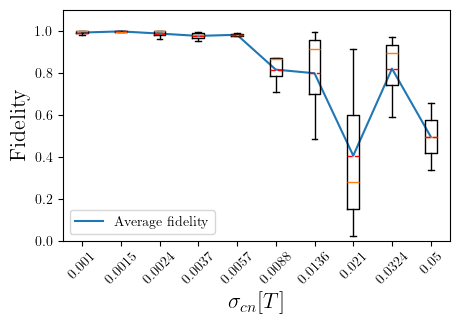

In [40]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 1

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.0010)  # Logaritmo base 10 de 0.001
stop = np.log10(0.05)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
range_std = np.logspace(start, stop, num=10)

Fidelity_mean(qcircuit_1_qubit_mixed, X, y, epocas, n_classes,
               nqubits, n_features , N_layers, range_std,
                 ket_0 = basis(2, 0), entgl = False,
                  coherent_noise = True, quantum_noise = False, n_lim = 40,
                  poinst = [70,70,1000])


Epoch: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


El código tardó 10.42415 segundos en ejecutarse.


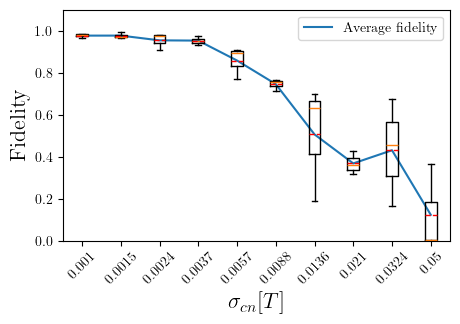

In [41]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 2

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.0010)  # Logaritmo base 10 de 0.001
stop = np.log10(0.05)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
range_std = np.logspace(start, stop, num=10)

Fidelity_mean(qcircuit_2_qubit_mixed, X, y, epocas, n_classes,
               nqubits, n_features , N_layers, range_std,
                 ket_0 = tensor(basis(2, 0), basis(2, 0)), entgl = False,
                  coherent_noise = True, quantum_noise = False, n_lim = 40, poinst = [70,70,1000])

Epoch: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


El código tardó 14.26988 segundos en ejecutarse.


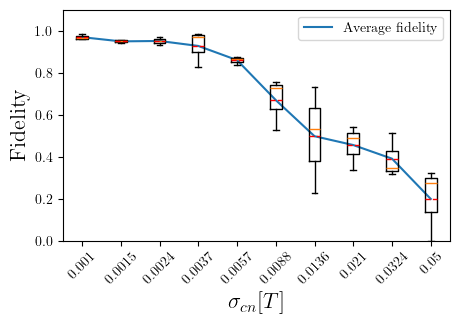

In [42]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 2

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.0010)  # Logaritmo base 10 de 0.001
stop = np.log10(0.05)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
range_std = np.logspace(start, stop, num=10)

Fidelity_mean(qcircuit_2_qubit_mixed, X, y, epocas, n_classes,
               nqubits, n_features , N_layers, range_std,
                 ket_0 = tensor(basis(2, 0), basis(2, 0)), entgl = True,
                  coherent_noise = True, quantum_noise = False, n_lim = 40, poinst = [70,70,1000])

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [01:16<00:00,  7.62s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


El código tardó 32.37580 segundos en ejecutarse.


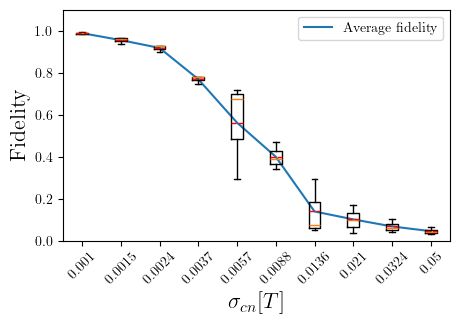

In [71]:
# nuevas
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 4

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.0010)  # Logaritmo base 10 de 0.001
stop = np.log10(0.05)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
range_std = np.logspace(start, stop, num=10)

Fidelity_mean(qcircuit_4_qubit_mixed, X, y, epocas, n_classes,
               4, n_features , N_layers, range_std,
                 ket_0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)), entgl = True,
                  coherent_noise = True, quantum_noise = False, n_lim = 40, poinst = [70,70,1000])

Epoch: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


El código tardó 8.13963 segundos en ejecutarse.


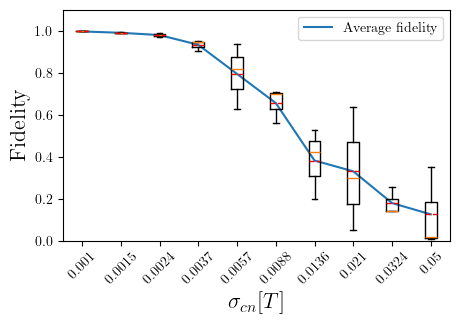

In [72]:
# nuevas
N_layers = 2
n_classes = 3
n_features = 2
epocas = 2

nqubits = 4

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.0010)  # Logaritmo base 10 de 0.001
stop = np.log10(0.05)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
range_std = np.logspace(start, stop, num=10)

Fidelity_mean(qcircuit_4_qubit_mixed, X, y, epocas, n_classes,
               4, n_features , N_layers, range_std,
                 ket_0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)), entgl = False,
                  coherent_noise = True, quantum_noise = False, n_lim = 40, poinst=[70,70,1000])

# T2

Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


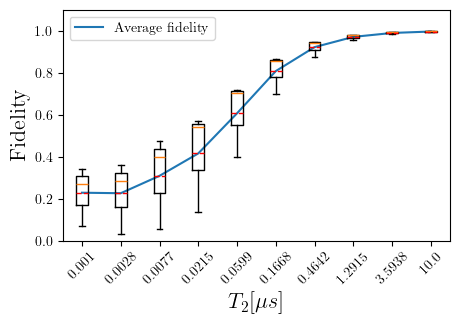

In [73]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 1


# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.001e-6)  # Logaritmo base 10 de 0.001
stop = np.log10(10e-6)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
T2_range = np.logspace(start, stop, num=10)

T2start_range = T2_range*5
T1_range = (1/2)*((T2_range*T2start_range)/(T2start_range - T2_range))

Fidelity_mean_T2(qcircuit_1_qubit_mixed, X, y, epocas, n_classes, 1, n_features , N_layers, T2_range, T1_range,
                    ket_0 = basis(2, 0), entgl = False,
                  coherent_noise = False, quantum_noise = True, n_lim = 40, poinst=[70,70,1000])

Epoch: 100%|██████████| 10/10 [00:39<00:00,  3.98s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


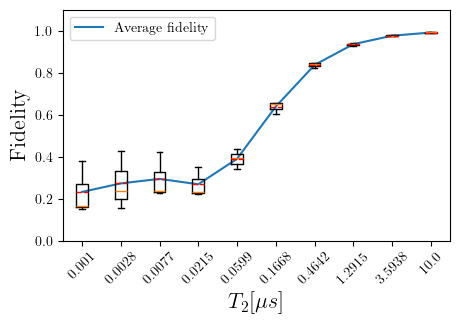

In [74]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 2

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)




start = np.log10(0.001e-6)  # Logaritmo base 10 de 0.001
stop = np.log10(10e-6)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
T2_range = np.logspace(start, stop, num=10)

T2start_range = T2_range*5
T1_range = (1/2)*((T2_range*T2start_range)/(T2start_range - T2_range))

Fidelity_mean_T2(qcircuit_2_qubit_mixed, X, y, epocas, n_classes, 2, n_features , N_layers, T2_range, T1_range,
                     ket_0 = tensor(basis(2, 0),basis(2, 0)), entgl = False,
                  coherent_noise = False, quantum_noise = True, n_lim = 40)

Epoch: 100%|██████████| 10/10 [00:39<00:00,  3.98s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


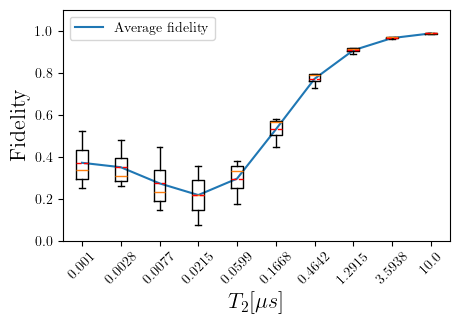

In [75]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 2

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)
start = np.log10(0.001e-6)  # Logaritmo base 10 de 0.001
stop = np.log10(10e-6)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
T2_range = np.logspace(start, stop, num=10)
T2start_range = T2_range*5
T1_range = (1/2)*((T2_range*T2start_range)/(T2start_range - T2_range))

Fidelity_mean_T2(qcircuit_2_qubit_mixed, X, y, epocas, n_classes, 2, n_features , N_layers, T2_range, T1_range,
                    ket_0 = tensor(basis(2, 0),basis(2, 0)), entgl = True,
                  coherent_noise = False, quantum_noise = True, n_lim = 40)

Epoch: 100%|██████████| 10/10 [01:22<00:00,  8.21s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


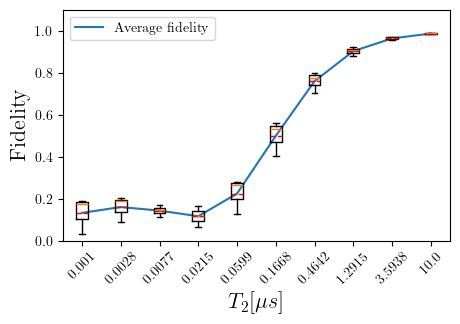

In [76]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 4

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.001e-6)  # Logaritmo base 10 de 0.001
stop = np.log10(10e-6)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
T2_range = np.logspace(start, stop, num=10)

Fidelity_mean_T2(qcircuit_4_qubit_mixed, X, y, epocas, n_classes, 4, n_features , N_layers, T2_range, T1_range,
                    ket_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)), entgl = False,
                  coherent_noise = False, quantum_noise = True, n_lim = 40)

Epoch: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


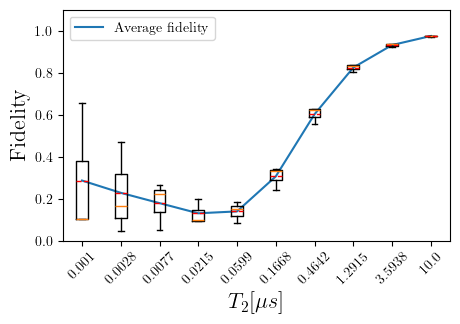

In [77]:
N_layers = 5
n_classes = 3
n_features = 2
epocas = 10

nqubits = 4

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# data set
X, y =  make_IRIS_v2(n_features, n_classes)

start = np.log10(0.001e-6)  # Logaritmo base 10 de 0.001
stop = np.log10(10e-6)     # Logaritmo base 10 de 0.05

# Genera 10 puntos uniformemente distribuidos en escala logarítmica
T2_range = np.logspace(start, stop, num=10)
T2start_range = T2_range*5
T1_range = (1/2)*((T2_range*T2start_range)/(T2start_range - T2_range))

Fidelity_mean_T2(qcircuit_4_qubit_mixed, X, y, epocas, n_classes, 4, n_features , N_layers, T2_range, T1_range,
                    ket_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)), entgl = True,
                  coherent_noise = False, quantum_noise = True, n_lim = 40)

# Prueba 2D - CN vs QN

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\UNALMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
c:\Users\UNALMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\numpy\numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)
c:\Users\UNALMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
Epoch: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


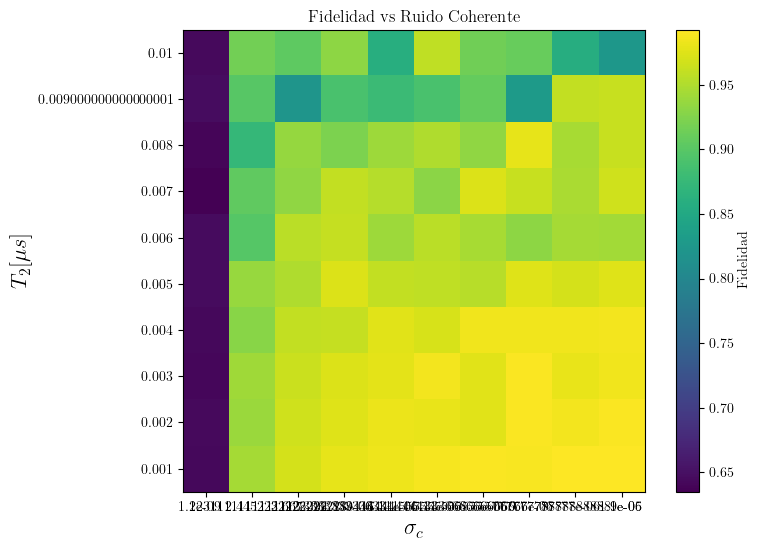

In [ ]:
range_std = np.linspace(0.0010, 0.01, 10)
T2_range= np.linspace(1e-9, 11e-6, 10)
ket_0 = basis(2, 0); entgl = False;
coherent_noise = True; quantum_noise = True; n_lim = 5;
# diccionario vacio defaul lista:
model_base_line = qcircuit_1_qubit_mixed
# fit base line model:
model = Modelo_DRU(model_base_line, fidelity_cost,
                epochs = epocas, n_clases = n_classes, n_qubits = nqubits,
                features = n_features, alpha_noise = 0.0, save_process=False,
                num_layers = N_layers, entanglement=entgl)
  # get tuning parameters:
paramters_iq, bias_iq = model.fit(X, y)
F_2d = np.zeros((len(range_std), len(T2_range)))
# fidelity vs coherent noise in XTest
for j in range(len(range_std)):
    for i in range(len(T2_range)):
        Fij = []
        for x in model.X_val[n_lim]:
            dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=200,
                                                N_qubits = nqubits,
                                                tf_noise = coherent_noise, noise_std = range_std[j],
                                                tf_quantum_noise = quantum_noise, T1= T1_range[i], T2 = T2_range[i],
                                                ket_dru_0 = ket_0, J=1e12)
            if nqubits == 1:
                state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_1_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
            elif nqubits == 2:
                state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_2_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)
            elif nqubits == 4:
                state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_iq,
                                                            x,
                                                            bias=bias_iq , entanglement=entgl)
                dm_baseline = qcircuit_4_qubit_mixed(paramters_iq, x, bias_iq, entanglement=entgl)

            # get dm of spins:
            dm_from_spins = state_dru*state_dru.dag().full()
            # fidelity:
            F  = qml.math.fidelity(dm_from_spins, dm_baseline)
            # save fidelity
            Fij.append(F)
        F_2d[j,i] = np.mean(Fij)

# Definir los valores de X, Y y Z para la superficie
X, Y = np.meshgrid(T2_range, range_std)
Z = F_2d

# Crear la figura y los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Etiquetas de los ejes
ax.set_xlabel('T2 Range')
ax.set_ylabel('Range Std')
ax.set_zlabel('Fidelidad')

# Título
ax.set_title('Fidelidad vs Ruido Coherente')

# Barra de color
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Graficar F_2d
plt.figure(figsize=(8, 6))
plt.imshow(F_2d, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar(label='Fidelidad')
plt.ylabel(r'$T_2 [\mu s]$',fontsize=16)
plt.xlabel(r'$\sigma_{c}$',fontsize=16)
plt.title('Fidelidad vs Ruido Coherente')
plt.xticks(range(len(T2_range)), T2_range)
plt.yticks(range(len(range_std)), range_std)
plt.show()
